In [1]:
%pip install pykrx

In [90]:
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta
from scipy import interpolate
from pandas import DataFrame, Series
import requests as re
from bs4 import BeautifulSoup
from pykrx import stock
from dateutil.relativedelta import relativedelta

#Set Fundamental Data

In [91]:
# 날짜 세팅
now = datetime.now()
# t = now.strftime('%Y%m%d')
t = '20230802'
t = datetime.strptime(t, '%Y%m%d')

In [92]:
# 기초자산 가격
# kospi 200
df = stock.get_index_ohlcv_by_date(t, t, "1028")
underlying = (float(df.종가))

# 옵션 데이터
option_data = stock.get_future_ohlcv(t, 'KRDRVOPK2I')

option_data.dropna(axis = 1, how='all', inplace=True)
option_data.dropna(axis = 0, how='any', inplace=True)

In [ ]:
# 금리 데이터 크롤링 및 보간 함수
def crawling_interest_rates(mydate:datetime):
    data_dict = {'IRR_CD91':[],
                 'IRR_CALL':[],
                 'IRR_GOVT03Y':[],
                 'IRR_CORP03Y':[]}
    label_list = ['IRR_CD91','IRR_CALL','IRR_GOVT03Y','IRR_CORP03Y']
    Data = DataFrame()
    for label in label_list:
        date_list = []
        try:
            for i in range(1, 10):
                url = re.get('http://finance.naver.com/marketindex/interestDailyQuote.nhn?marketindexCd=%s&page=%s'%(label,i))
                url = url.content
                soup = BeautifulSoup(url,'html.parser')

                # 날짜 가져오기
                dates = soup.select('tr > td.date')

                # 빈테이지인지 테스트
                try:
                    test = soup.find('tbody').find('tr').find('td',{'class':'num'}).text # .text가 에러를 반환하는가?
                except:
                    break

                # 처음 한번만 가져오자
                for date in dates:
                    date_list.append(date.text.strip())

                rates = soup.find('tbody').find_all('tr')
                for rate in rates:
                    data_dict[label].append(rate.find('td',{'class':'num'}).text.strip())

        except:
            print('Error')

        temp_dataframe = DataFrame(data_dict[label], index = date_list)
        Data = pd.merge(Data,temp_dataframe,how = 'outer', left_index = True, right_index = True)

    Data.columns = ['CD91일', '콜 금리', '국고채 3년', '회사채 3년']

    Data.index = pd.to_datetime(Data.index)
    my_data = Data[Data.index==mydate]


    # 금리 interpolation
    x = [91, 252*3]
    y = [float(my_data['CD91일']), float(my_data['국고채 3년'])]

    linear_func = interpolate.interp1d(x, y, kind='linear')

    x_new = 91
    y1 = float(y[0]) / (60*24*365)
    y2 = float(linear_func(x_new+30) / (60*24*365))
    return [y1, y2], Data.dropna()

rates, data_df = crawling_interest_rates(t)

In [ ]:
# 매월 옵션 만기일
# 월요일은 0, 목요일은 3
def nth_weekday(the_date, nth_week, week_day):
    temp = the_date.replace(day=1)
    adj = (week_day - temp.weekday()) % 7
    temp += timedelta(days=adj)
    temp += timedelta(weeks=nth_week-1)
    return temp

# 근월물 옵션 만기일 구하기
def get_near_due(mydate:datetime)->datetime:
    # get 2nd thursday of the same month
    thismonth_duedate = nth_weekday(mydate, 2, 3)
    # in case today already passed the duedate (10/15) -> get nextmonth_duedate
    if mydate <= thismonth_duedate:
        return thismonth_duedate
    elif mydate > thismonth_duedate :
        nextmonth_duedate = nth_weekday(mydate+relativedelta(months=1),2, 3)
        return nextmonth_duedate

# 원월물 옵션 만기일 구하기
def get_next_due(mydate:datetime)->datetime:
    # get 2nd thursday of the same month
    thismonth_duedate = nth_weekday(mydate+relativedelta(months=1), 2, 3)
    # in case today already passed the duedate (10/15) -> get nextmonth_duedate
    if mydate <= thismonth_duedate:
        return thismonth_duedate
    elif mydate > thismonth_duedate :
        nextmonth_duedate = nth_weekday(mydate+relativedelta(months=2),2, 3)
        return nextmonth_duedate


# 날짜 차이 구하기
def date_diff(now, future):
  gap = future - now
  return gap.days

In [ ]:
near_date = get_near_due(t)
next_date = get_next_due(t)

near_date_diff = date_diff(t, get_near_due(t))
next_date_diff = date_diff(t, get_next_due(t))

In [ ]:
# risk-free interest rate
# rates=[0.0002945, 0.00039691]

# [근일물, 원일물] time set
Nt=[60*24*near_date_diff, 60*24*next_date_diff]		#seconds
T=[Nt[0]/(60*24*365), Nt[1]/(60*24*365)]	#years

# VKOSPI

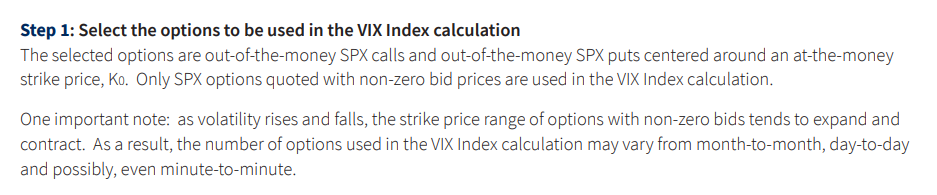

In [ ]:
# Step 0: Split Near Term and Next Term

near_option_data = pd.DataFrame()
for i in option_data.종목명:
  if near_date.strftime('%Y%m') in i:
    near_option_data = pd.concat([near_option_data, option_data[option_data['종목명'] == i]])


next_option_data = pd.DataFrame()
for i in option_data.종목명:
  if next_date.strftime('%Y%m') in i:
    next_option_data = pd.concat([next_option_data, option_data[option_data['종목명'] == i]])

In [ ]:
# Step 0.1: make near, next term option datafield
near_term_option = pd.DataFrame()

near_option_data['Strike_Price'] = near_option_data['종목명'].str[-5:]
near_option_data['Option_Type'] = near_option_data['종목명'].str[7]

near_data = []
for i in near_option_data.Strike_Price:
  check = near_option_data[near_option_data.Strike_Price == i]
  if len(check) == 2:
    input_data = []
    # [Strike Price, Call Close, Put Close, Difference]
    input_data.append(float(check['Strike_Price'].unique()))
    input_data.append(check['종가'].to_list()[0])
    input_data.append(check['종가'].to_list()[1])
    input_data.append(abs(check['종가'].to_list()[0]-check['종가'].to_list()[1]))
    if input_data not in near_data:
      near_data.append(input_data)
  else:
    pass

near_term_option = pd.concat([near_term_option, pd.DataFrame(near_data)])
near_term_option.columns = ['Strike_Price', 'Call', 'Put', 'Difference']
near_term_option = near_term_option[(near_term_option['Call']!=0) & (near_term_option['Put']!=0)]

next_term_option = pd.DataFrame()

next_option_data['Strike_Price'] = next_option_data['종목명'].str[-5:]
next_option_data['Option_Type'] = next_option_data['종목명'].str[7]

next_data = []
for i in next_option_data.Strike_Price:
  check = next_option_data[next_option_data.Strike_Price == i]
  if len(check) == 2:
    input_data = []
    # [Strike Price, Call Close, Put Close, Difference]
    input_data.append(float(check['Strike_Price'].unique()))
    input_data.append(check['종가'].to_list()[0])
    input_data.append(check['종가'].to_list()[1])
    input_data.append(abs(check['종가'].to_list()[0]-check['종가'].to_list()[1]))
    if input_data not in next_data:
      next_data.append(input_data)
  else:
    pass

next_term_option = pd.concat([next_term_option, pd.DataFrame(next_data)])
next_term_option.columns = ['Strike_Price', 'Call', 'Put', 'Difference']
next_term_option = next_term_option[(next_term_option['Call']!=0) & (next_term_option['Put']!=0)]


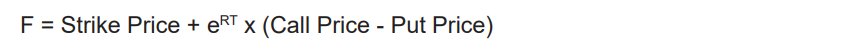

In [ ]:
# F1: near term 합성 선물, F2: next term 합성 선물
F1_data = near_term_option[near_term_option['Difference'] == near_term_option['Difference'].min()]
F2_data = next_term_option[next_term_option['Difference'] == next_term_option['Difference'].min()]

F1 = float(F1_data['Strike_Price'] + math.exp(rates[0] * T[0]) * (F1_data['Call'] - F1_data['Put']))
F2 = float(F2_data['Strike_Price'] + math.exp(rates[1] * T[1]) * (F2_data['Call'] - F2_data['Put']))

# K_0,1 K_0,2 = K0 - the strike price
K_0_1 = near_term_option[(near_term_option['Strike_Price'].astype(float) - F1 < 1)].Difference == near_term_option[(near_term_option['Strike_Price'].astype(float) - F1 < 1)].Difference.min()
K_0_1 = float(near_term_option[(near_term_option['Strike_Price'].astype(float) - F1 < 1)][K_0_1].Strike_Price)
K_0_2 = next_term_option[(next_term_option['Strike_Price'].astype(float) - F2 < 1)].Difference == next_term_option[(next_term_option['Strike_Price'].astype(float) - F2 < 1)].Difference.min()
K_0_2 = float(next_term_option[(next_term_option['Strike_Price'].astype(float) - F2 < 1)][K_0_2].Strike_Price)

print(K_0_1, K_0_2)

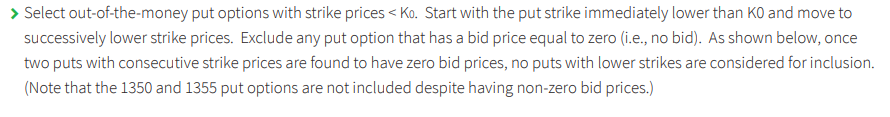

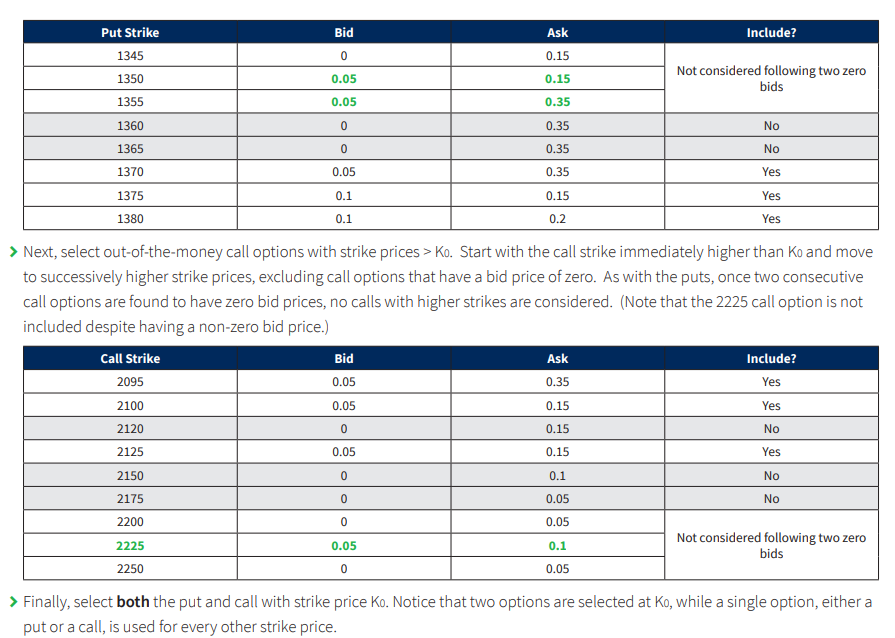

In [ ]:
near_option_data_call = near_option_data[near_option_data['Option_Type'] == 'C']
near_option_data_put = near_option_data[near_option_data['Option_Type'] == 'P']
next_option_data_call = next_option_data[next_option_data['Option_Type'] == 'C']
next_option_data_put = next_option_data[next_option_data['Option_Type'] == 'P']

In [ ]:
near_option_data_call['Strike_Price_Diff'] = near_option_data_call['Strike_Price'].astype(float).diff()
near_option_data_put['Strike_Price_Diff'] = near_option_data_put['Strike_Price'].astype(float).diff()
next_option_data_call['Strike_Price_Diff'] = next_option_data_call['Strike_Price'].astype(float).diff()
next_option_data_put['Strike_Price_Diff'] = next_option_data_put['Strike_Price'].astype(float).diff()

In [ ]:
# following_two_cutoff 함수
def following_two_cutoff(data: pd.DataFrame):
  filter = data['Strike_Price_Diff'] < 7.5
  filter = list(filter)
  center = int(len(filter) / 2)
  flag = True
  while center != 0:
    if filter[center] == False:
      filter[center] = flag
      flag = False
    else:
      filter[center] = flag
    center -= 1

  center = int(len(filter) / 2)
  flag = True
  while center != (len(filter)-1):
    if filter[center] == False:
      flag = False
    filter[center] = flag
    center += 1

  return filter

# Cutoff 함수
def cutoff(data: pd.DataFrame):
  if data['Option_Type'].unique() == 'C':
    data_cutoff = data[following_two_cutoff(data)]
    data_cutoff = data_cutoff[data_cutoff['Strike_Price'].astype(float) > underlying]
  if data['Option_Type'].unique() == 'P':
    data_cutoff = data[following_two_cutoff(data)]
    data_cutoff = data_cutoff[data_cutoff['Strike_Price'].astype(float) < underlying]
  return data_cutoff

In [ ]:
near_call = cutoff(near_option_data_call)
near_put = cutoff(near_option_data_put)
next_call = cutoff(next_option_data_call)
next_put = cutoff(next_option_data_put)

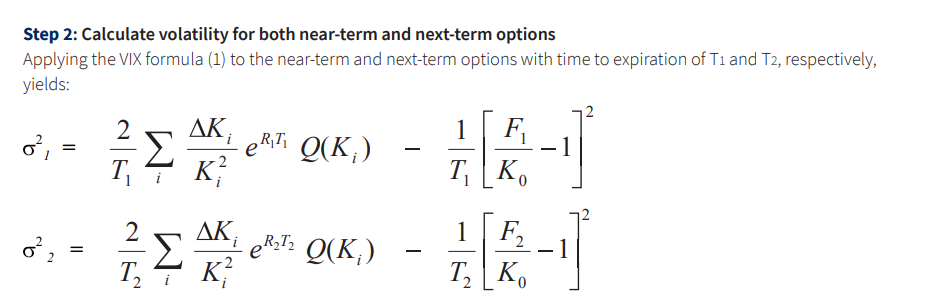

In [ ]:
near_call['Contribution_by_Strike'] = (2.5/(near_call['Strike_Price'].astype(float).pow(2))) * math.exp(rates[0] * T[0]) * near_call['종가']
near_put['Contribution_by_Strike'] = (2.5/(near_put['Strike_Price'].astype(float).pow(2))) * math.exp(rates[0] * T[0]) * near_put['종가']
next_call['Contribution_by_Strike'] = (2.5/(next_call['Strike_Price'].astype(float).pow(2))) * math.exp(rates[1] * T[1]) * next_call['종가']
next_put['Contribution_by_Strike'] = (2.5/(next_put['Strike_Price'].astype(float).pow(2))) * math.exp(rates[1] * T[1]) * next_put['종가']

In [ ]:
near = pd.concat([near_call, near_put])
next = pd.concat([next_call, next_put])

In [ ]:
sigmasquared_1 = (2/T[0])*near['Contribution_by_Strike'].sum() - (1/T[0])*((F1/K_0_1)-1)**2
sigmasquared_2 = (2/T[1])*next['Contribution_by_Strike'].sum() - (1/T[1])*((F2/K_0_2)-1)**2

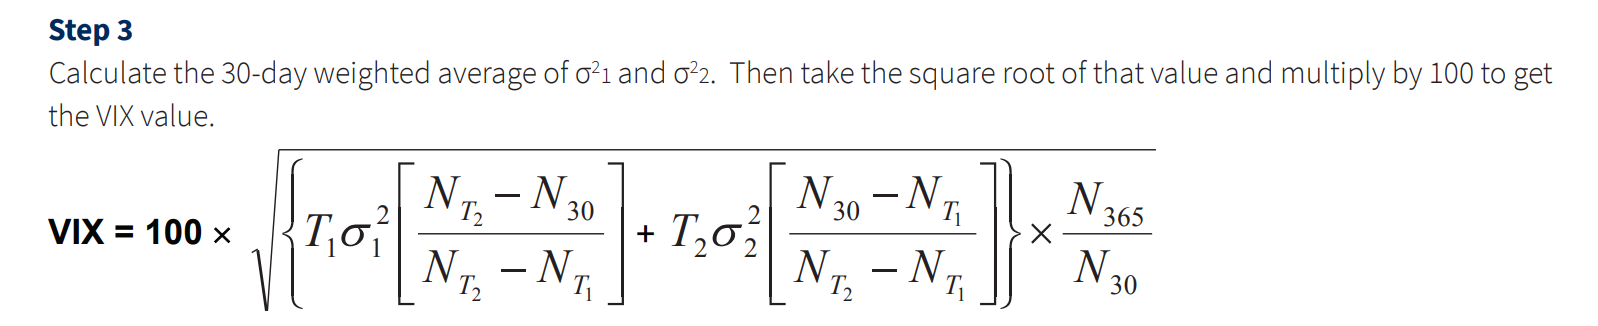

In [ ]:
N30 = 60*24*30
N365 = 60*24*365
VIX = 100 * np.sqrt((T[0]*sigmasquared_1*((Nt[1]-N30)/(Nt[1]-Nt[0]))+T[1]*sigmasquared_2*((N30-Nt[0])/(Nt[1]-Nt[0])))*(N365/N30))
VIX